In [96]:
#!cat ua.base 
#파일 가져오기 (Google mount ...)

In [97]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [98]:
#tab 으로 구분됨 == csv 파일 ~> Pandas 사용
#csv == {1, 2, ...}

train = pd.read_csv("ua.base", sep = "\t", names = ['user', 'movie', 'rating', 'timestamp']) #sep = "," 인데 "\t"으로 설정
test = pd.read_csv("ua.test", sep = "\t", names = ['user', 'movie', 'rating', 'timestamp'])

#train
test

,user,movie,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201
...,...,...,...,...
9425,943,232,4,888639867
9426,943,356,4,888639598
9427,943,570,1,888640125
9428,943,808,4,888639868


In [99]:
#pytorch에서 데이터를 다루는데 pandas는 쓸 수 없음 ~> tensor로 바꿈
#column 별로

#train Data
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])

#test Data
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

print("Train : items : {}, users : {}, ratings : {}".format(items, users, ratings))
print("Test : items : {}, users : {}, ratings : {}".format(items_test, users_test, ratings_test))

Train : items : tensor([   1,    2,    3,  ..., 1188, 1228, 1330]), users : tensor([  1,   1,   1,  ..., 943, 943, 943]), ratings : tensor([5., 3., 4.,  ..., 3., 3., 3.])
Test : items : tensor([  20,   33,   61,  ...,  570,  808, 1067]), users : tensor([  1,   1,   1,  ..., 943, 943, 943]), ratings : tensor([4., 4., 4.,  ..., 1., 4., 2.])


In [100]:
#LatentFacto Model ~> 두 matrix의 내적과 ratings을 통해 학습

rank = 30 #param으로 지정
numItems = items.max() + 1
numUsers = users.max() + 1 #item, user의 갯수를 알아야 하기 때문에 (live하게)

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True) #P, Q는 num x rank 인 Matrix

#print("P : {}, Q : {}, P * Q : {}, P . Q : {}".format(P[123], Q[3], P[123] * Q[3], torch.sum(P[123] * Q[3])))

#ID ; 3 인 user가 ID ; 123 인 Movie 의 예상별점???
#torch.sum(P[123] * Q[3])

optimizer = torch.optim.Adam([P, Q], lr = 0.1)
X = []
Y = [] #plot을 위한 list
Y_Test = []

#즉, movie에 대한 정보를 rank만큼으로 속성을 만들어 놓은 (len(items) x rank) matrix에서 원하는 movie에 대한 matrix를 가져옴
print("P : {}, P_Items : {}".format(P, P[items])) #items에 있는 idx를 가지고 matrix로 만듦

lambda1 = 0.0001
lambda2 = 0.0001 #param, 너무 크면 학습 잘 안됨
lambda3 = 0.0001
lambda4 = 0.0001

bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True) #bias item, user 학습을 위해 rand
mean = (ratings.sum() / len(ratings)).item()

#cost
for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users] #가설함수
  cost = F.mse_loss(hypothesis, ratings) #== cost = torch.mean((hypothesis - ratings) ** 2)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2) #overfitting 을 방지하기 위해

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    #test 는 fitting 이 아니므로 bias, mean 등 필요 x..? P, Q에 대해서도 필요 x?
    hypothesis_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypothesis_test, ratings_test)

  X.append(epoch)
  #Y.append(cost.item()) #X ; Epoch, Y : Cost
  Y.append(loss.item())
  Y_Test.append(cost_test.item())

  if epoch % 100 == 0:
    print("epoch : {}, cost : {}".format(epoch, cost.item()))

P : tensor([[ 0.8131, -0.5544, -0.4819,  ..., -1.5749, -1.8510,  0.4183],
        [-0.1653, -0.5182,  0.1338,  ...,  1.6686, -1.1964, -1.2260],
        [ 0.3102, -0.7297,  1.1516,  ..., -0.3724, -1.2724,  0.5957],
        ...,
        [-1.2130,  0.4231, -0.8449,  ..., -1.7515,  0.0272,  1.2075],
        [-0.0344, -0.5236,  1.3242,  ..., -0.1310,  0.0769,  0.2382],
        [-0.9658, -1.2344, -1.4603,  ..., -0.7738,  0.3726, -1.0590]],
       requires_grad=True), P_Items : tensor([[-0.1653, -0.5182,  0.1338,  ...,  1.6686, -1.1964, -1.2260],
        [ 0.3102, -0.7297,  1.1516,  ..., -0.3724, -1.2724,  0.5957],
        [-0.1250,  0.6572,  1.5263,  ...,  2.0352,  0.4249, -0.1326],
        ...,
        [-2.1783,  0.6845,  0.8352,  ..., -0.4665, -0.7800, -0.4073],
        [ 0.2396, -0.4068,  1.3971,  ...,  0.0697, -0.5945,  0.3960],
        [ 1.2791,  1.6719, -0.3817,  ..., -0.3020,  1.2781,  0.9309]],
       grad_fn=<IndexBackward>)
epoch : 0, cost : 33.81050109863281
epoch : 100, cost : 0.

In [101]:
#Test

torch.sum(P[2] * Q[1]) 
#실제점수 3점
#rank = 10 일때, 1번 usr가 2번 영화에 3.2523로 예측
#rank = 50 일때, 1번 usr가 2번 영화에 2.8481로 예측 ~> 오히려 어긋나는듯 ??
#rank = 30 일때, 1번 usr가 2번 영화에 3.2148로 예측
#rank = 40 일때, 2.7382
#rank = 60 일때, 2.8733 ... 아마 rank가 더 커지면 더 근사할것 
#rank = 30, lambda 1, 2 = 0.0001 ~> 3.0417
#rank = 30, lambda 1, 2 = 0.00001 ~> 2.9615 (더 안좋아짐)
#rank = 30, lambda 1, 2 = 0.0002 ~> 3.1342 (안 좋음) 근데 plot 은 오히려 더 근사..?

tensor(0.4080, grad_fn=<SumBackward0>)

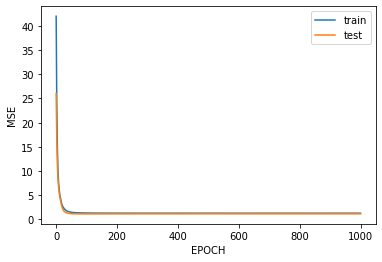

In [102]:
#Plot Show

plt.ylabel("MSE")
plt.xlabel("EPOCH")
plt.plot(X, Y, label='train')
plt.plot(X, Y_Test, label='test')
plt.legend()

plt.show()